<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/03_k_space_sampling/notebooks/02_radial_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Radial sequences (solutions)

---
Solutions
---
---

- **In the sequence code below, the current implementation is the solution after exercise 1.2. Change to golden angle (exercise 1.3) can be done by uncommented the new `delta` below.**
- **The solution for exercise 2 (radial stack-of-stars) is in a separate notebook.**

---
&nbsp;
---

In this exercise we will modify the standard gradient echo radial sequence that is provided by (py)Pulseq. You can find the exercises at the bottom of this notebook!

## Initialization

In [1]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, recon_nufft_2d, ifft_1d, plot_nd

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


File ‘utils.py’ already there; not retrieving.



# **Create, simulate, and reconstruct sequence**

**Radial GRE Sequence definition**

In [2]:
plot = False
write_seq = False
animate_sequence = True

seq_filename = "gre_radial.seq"

# ======
# SETUP
# ======
fov = 256e-3
Nx = 128  # Define FOV and resolution
alpha = 30  # Flip angle
slice_thickness = 5e-3  # Slice thickness
TE = 3.5e-3  # Echo time
TR = 5.7e-3  # Repetition time
# Nr = 128 # Number of radial spokes

# Ex 1.2. Number of radial spokes for Nyquist sampling on the k-space edge
# Solved for arc length between two spokes = 1/fov
Nr = math.ceil(Nx/2 * np.pi)-1

# Ex 1.1 Increasing dummy scans to 50 is close enough to get to steady-state (see plots below)
N_dummy = 50  # Number of dummy scans
delta = np.pi / Nr  # Angular increment

# Ex 1.3: Golden angle increment
# delta = np.pi * (3 - np.sqrt(5))  # Angular increment

ro_os = 2 # Readout oversampling
rf_spoiling_inc = 117  # RF spoiling increment

# Set system limits
system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

seq = pp.Sequence(system)  # Create a new sequence object

# ======
# CREATE EVENTS
# ======
# Create alpha-degree slice selection pulse and gradient
rf, gz, _ = pp.make_sinc_pulse(
    apodization=0.5,
    duration=1e-3,
    flip_angle=alpha * np.pi / 180,
    slice_thickness=slice_thickness,
    system=system,
    time_bw_product=4,
    return_gz=True,
)
gz_reph = pp.make_trapezoid(channel="z", area=-gz.area / 2, duration=2e-3, system=system)

# Define other gradients and ADC events
deltak = 1 / fov
gx = pp.make_trapezoid(channel="x", flat_area=Nx * deltak, flat_time=6.4e-3 / 5, system=system)
adc = pp.make_adc(num_samples=Nx*ro_os, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel="x", area=-gx.area / 2, duration=2e-3, system=system)

# Gradient spoiling
gx_spoil = pp.make_trapezoid(channel="x", area=0.5 * Nx * deltak, system=system)
gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre, gz_reph)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(gz, rf)
            - pp.calc_duration(gx_pre, gz_reph)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
assert delay_TR >= pp.calc_duration(gx_spoil, gz_spoil)

rf_phase = 0
rf_inc = 0

# ======
# CONSTRUCT SEQUENCE
# ======
for i in range(-N_dummy, Nr):
    # Set RF/ADC phase for RF spoiling, and increment RF phase
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi

    rf_inc = (rf_inc + rf_spoiling_inc) % 360.0
    rf_phase = (rf_phase + rf_inc) % 360.0

    # Slice-selective excitation pulse
    seq.add_block(rf, gz)

    # Slice rephaser and readout pre-phaser
    phi = delta * (i)
    seq.add_block(*pp.rotate(gx_pre, angle=phi, axis="z"), gz_reph)

    # Wait so readout is centered on TE
    seq.add_block(pp.make_delay(delay_TE))

    # Readout gradient, rotated by `phi`
    if i >= 0:
        # Real scan, readout gradient + ADC object
        seq.add_block(*pp.rotate(gx, angle=phi, axis="z"), adc)
    else:
        # Dummy scan, do not add ADC object
        seq.add_block(*pp.rotate(gx, angle=phi, axis="z"))

    # GX/GZ spoiler gradient, and wait for TR
    seq.add_block(*pp.rotate(gx_spoil, angle=phi, axis="z"), gz_spoil, pp.make_delay(delay_TR))

# Timing check
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed! Error listing follows:")
    print(error_report)

# ======
# VISUALIZATION
# ======
if plot:
    seq.plot()

# Print test report
print(seq.test_report())

# =========
# WRITE .SEQ
# =========
seq.set_definition(key="FOV", value=[fov, fov, slice_thickness])

if write_seq:
    seq.set_definition(key="Name", value="gre_rad")
    seq.write(seq_filename)

Timing check passed successfully
Number of blocks: 1255
Number of events:
RF:    251
Gx:    753
Gy:    750
Gz:    753
ADC:    201
Delay:      0
Sequence duration: 1.433210 s
TE: 0.003500 s
TR: 0.005710 s
Flip angle: 30.00 deg
Unique k-space positions (aka cols, rows, etc.): 25644 25463 
Dimensions: 2
Spatial resolution: 2.01 mm
Spatial resolution: 2.01 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Event timing check passed successfully
Max gradient: 1190476 1190440 1176471 Hz/m == 27.96 27.96 27.63 mT/m
Max slew rate: 6265664160 6265472831 6191950464 Hz/m/s == 147.16 147.16 145.43 T/m/s
Max absolute gradient: 1673713 Hz/m == 39.31 mT/m
Max absolute slew rate: 8.80901e+09 Hz/m/s == 206.90 T/m/s


Calculate the distance between the last sample of the first readout and the last sample of the second readout, to check the Nyquist condition. This only works for linear steps in acquisition angle.

In [3]:
if delta == np.pi/Nr:
    k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()
    deltak_edge = np.linalg.norm(k_traj_adc[:,adc.num_samples-1] - k_traj_adc[:,2*adc.num_samples-1])
    if deltak_edge >= deltak*1.001: # Allow for small error
        print(f'Not Nyquist sampled! {deltak / deltak_edge * 100:.1f}% ☹️')
    else:
        print(f'Nyquist sampled! {deltak / deltak_edge * 100:.1f}% 🥳')

Nyquist sampled! 100.4% 🥳


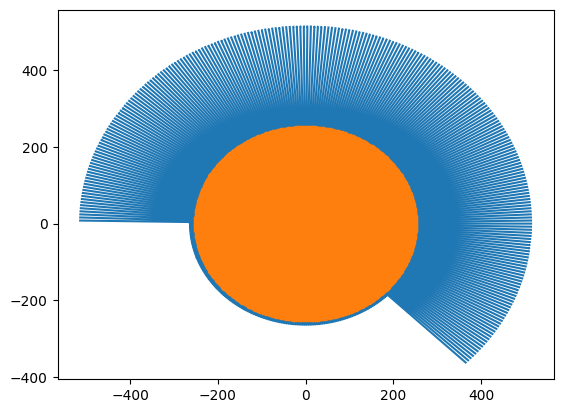

In [4]:
# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

**Animate trajectory**

In [5]:
if animate_sequence:
    ani = animate(seq, show=False, dt=seq.duration()[0] / 10, plot_window=seq.duration()[0], fps=10, show_progress=True)
    display(HTML(ani.to_html5_video()))

  0%|          | 0/10 [00:00<?, ?it/s]

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles, as well as the so-called sinogram.

In a radial acquisition, every acquired line is a projection of all signal perpendicular to the acquisition angle. By performing a 1D FFT over the readout direction, we can calculate that projection in image space, and display it.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 251 / 251 - done


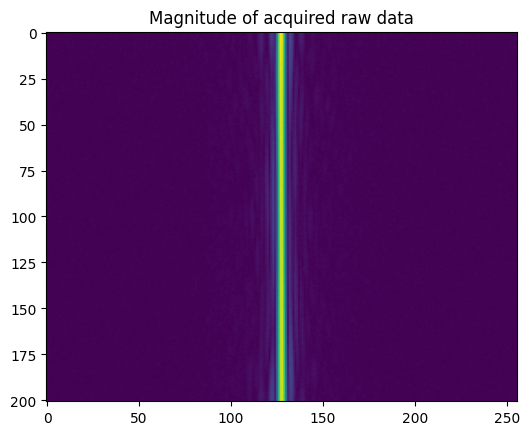

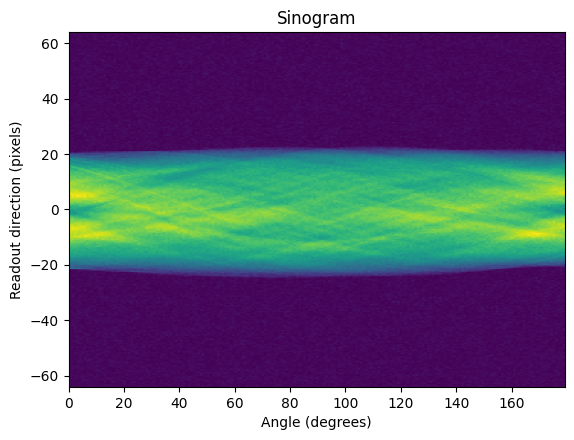

In [6]:
# Simulate sequence
kdata = simulate_2d(seq, sim_size=[128,128], noise_level=0.5, n_coils=1).conj()

# Display raw data profiles
plt.figure()
plt.imshow(abs(kdata[0]))
plt.title('Magnitude of acquired raw data')

# Display sinogram, first sort data according to acquisition angle
angles = (np.arange(Nr)*delta) % (2*np.pi)
angle_inds = np.argsort(angles)

plt.figure()
plt.imshow(abs(ifft_1d(kdata[0, angle_inds])).T,
           extent=[angles[angle_inds[0]]/(2*np.pi)*360,angles[angle_inds[-1]]/(2*np.pi)*360,-Nx/2,Nx/2])
plt.title('Sinogram')
plt.ylabel('Readout direction (pixels)')
plt.xlabel('Angle (degrees)');

**Reconstruction**

To reconstruct non-Cartesian data, we need to use the non-uniform FFT (NUFFT). Here, we provide the `recon_nufft_2d` function to reconstruct non-Cartesian data using a NUFFT, and using the k-space trajectory calculated by `seq.calculate_kspace`.

***Implementation details***: Instead of using density-compensation, we used an iterative solver to solve `minimize ||NUFFT(rec) - kdata|| + lambda*||rec||`. The second term is a regularization term, that penalizes high values in voxels (L2 norm), which suppresses some of the most obvious aliasing artifacts.

There exist various density-compensation algorithms that would allow us to do this reconstruction with a single inverse NUFFT (i.e. `adj_NUFFT(kdata * density)`), assuming the data is sampled with a sufficient density.

LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

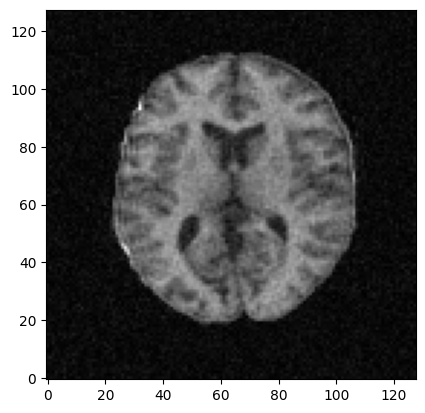

In [7]:
rec = recon_nufft_2d(kdata, seq, (Nx, Nx))

plot_nd(rec)

**Reconstruction: Compressed Sensing**

Since we are using iterative reconstruction, it is easy to add a more complicated regularization term. Here, we penalize the differences between neighouring voxels (called Total Variation regularization). The result of this is that the reconstruction will tend towards piecewise-constant values. Even in Nyquist-sampled acquisitions, a reconstruction like this will suppress noise.  The higher the regularization term `lambda_tv`, the stronger this effect will be.

***Implementation details:*** Internally this uses `sigpy.mri.app.TotalVariationRecon`, a ready made solution provided by `sigpy` to do such reconstructions easily. Although this is one of the most easy functions to use, there exist many other software packages to do iterative reconstructions! (e.g. BART).

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

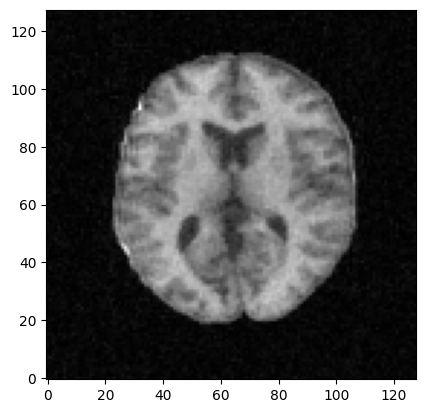

In [8]:
rec = recon_nufft_2d(kdata, seq, (Nx, Nx), lambda_tv=0.1)

plot_nd(rec)

# Exercises

Note: If you want the whole notebook to run a bit faster, consider setting `animate_sequence = False` and commenting out the Compressed Sensing reconstruction block.

## 1. Warmup exercises

Run the full notebook. The reconstructed images do not look very good!

***1.1 Steady state***

- Look at the magnitude of the raw data and sinogram, what effect do you observe?

This implementation includes the `N_dummy` parameter, which sets the number of repetitions of the pulse sequence that is run at the start of acquisition, without measuring data.

- Increase `N_dummy` such that the intensity of the k-space profiles looks more homogeneous, and the reconstruct image looks nicer. Note: Increasing dummy scans also increases total scan time (and in this notebook: simulation time!). So it is best not to put it too high.

***1.2 Number of radial spokes***

In this example, we set the number of radial spokes (`Nr` parameter) somewhat arbitrarily to 128. Of course, this parameter depends on the desired FOV (the `fov` parameter) and resolution (defined by `Nx`, the readout length).

- How many spokes do we need to sample a radial k-space according to the Nyquist limit? Note that the k-space coverage is the worst at the edge of k-space, and that in order to achieve a nominal FOV, k-space samples need to be `1/FOV` apart. The code block directly after the sequence definition checks this condition!

- What happens to the image if we acquire less spokes than the nominal amount?

Radial sampling is intrinsically very well-suited for Compressed Sensing (CS) reconstruction, which can very effectively reduce undersampling artifacts.

- Have a look at the CS reconstruction above. `lambda_tv` controls the regularization strength (i.e. how smooth do we assume the image to be). Play around with different acceleration factors by reducing `Nr` (e.g. reduce by 2x, 4x, etc.), and try to get good reconstructions by varying the `lamdba_tv` parameter.


***1.3 Golden angle radial***

In the parameters at the start, `delta` defines the increment of the acquisition angle between two successive acquisitions. It is set to `180/Nr` degrees (defined in radians: `np.pi/Nr`), i.e. it linearly goes over all angles between 0 and 180, as can be seen in the k-space animation.

A common scheme for radial acquisitions is to use a golden angle increment (https://en.wikipedia.org/wiki/Golden_angle).

- Change `delta` to be the golden angle.

When the acquisition is in steady-state, and motion and other artifacts are absent (as in our simulation), the effect of this change is not immediately obvious. As a demonstration of signal varying over time, we can acquire signal partially in the transient state.

- Change `N_dummy` back to 0 and simulate the sequence. While the contrast of the image is still not very good, the artifacts appear very different, purely because of the sampling scheme! Similar to profile ordering in Cartesian sampling, this can be very useful in practice when dealing with motion, magnetization-prepared acquisitions, etc. Change `N_dummy` back to a reasonable number for the next exercise.

Golden angle radial sampling is especially useful in dynamic acquisitions as it allows reconstruction from an arbitrary subset of acquired lines.

In the `recon_nufft_2d` function we included a parameter to reconstruct from a subset of the acquired lines. In your own work you would probably implement the reconstruction yourself and be able to do this with more flexibility.

- Modify the CS reconstruction above to use the `profile_range` parameter, as follows to reconstruct the 20th up to 40th acquisition (not inclusive), for example:

```rec = recon_nufft_2d(kdata, seq, (Nx, Nx), lambda_tv=0.1, profile_range=[20,40])```

- Play around with the number of acquisitions and which part of the sequence the acquisitions are taken from. Does it matter?

Even heavily undersampled radial sequences can be used to reconstruct meaningful data, especially with CS reconstruction. In dynamic acquisitions, smoothness in the time dimension is often enforced in the reconstruction to recover better spatial resolution from a limited number lines acquired per frame.

## 2. Optional, advanced exercise: 3D Stack-of-stars

Only start this if you have plenty of time and feel very comfortable with pypulseq at this point. It is probably best to continue with exercise 3 first and coming back to this exercise if time permits. Otherwise, consider this a take-home exercise!

The radial sequence here is limited to 2D imaging. It is possible to use 2D multislice imaging to acquire a 3D volume, but this has various issues. It is possible to do true, 3D imaging with radial sequences. One such variant is stack-of-stars, where we use Cartesian phase-encoding in the Z direction, and radial encoding in the XY-plane.

- Start by increasing `slice_thickness`, and adding a `Nz` parameter, for the number of slices. Note that we will be encoding `Nz` voxels in a `slice_thickness` thick volume (i.e. the true slice thickness or Z-resolution = `slice_thickness / Nz`).

- In addition to a rephasing gradient in the Z-direction, we will now also need a phase encoding gradient. Call this `gz_pre`, and make sure to design it for the maximum gradient area required to encode further point in k-space (i.e. `1/slice_thickness * Nz/2`).
  - You could borrow this from a phase-encoded Cartesian sequence, such as the one used in exercise 1.

- Now the sequence will need an additional loop over the `Nz` phase-encodes. This could be either the inner or outer loop, depending on whether you would want to acquire all `Nz` phase-encodes per radial line first, or whether to acquire one "star" at a time, one phase-encode at a time. Choose one, and add `gz_pre` to the sequence, making sure to that it is scaled with the phase-encoding step.
  - Alternatively, recreate `gz_pre` in each repetition with the correct gradient area. In this case, make sure to manually set a `duration`, to avoid `TE` changing per phase-encode.
  - Note that `gz_pre` and `gz_reph` could be combined for better time-efficiency. You can optionally do this now (recreate the phase encoding gradient within the sequence loop, with the correct area).

- Finally, if you have added new blocks to the sequence, make sure to update the calculations for `delay_TE` and `delay_TR`.

If all went well, you now have a 3D radial stack-of-stars sequence! For slightly better k-space coverage, the acquisition angle could be varied per phase-encode in Z. Note that we do not include a 3D simulation object, so to test the sequence you will need to take the sequence to a scanner! The `utils.py` file does contain a `recon_nufft_3d` function for 3D trajectories in general, although a proper reconstruction would do a 1D FFT in the slice direction and non-Cartesian reconstruction in the XY-plane only.